In [25]:
import pandas as pd
from datetime import datetime
from osgeo import gdal
import numpy as np
import subprocess
import glob
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from dateutil.parser import parse
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

In [11]:
train_labels = pd.read_csv("train_labels.csv")
grid_metadata = pd.read_csv("grid_metadata.csv")
satellite_metadata = pd.read_csv("pm25_satellite_metadata.csv")
satellite_metadata['Date'] =  pd.to_datetime(satellite_metadata['time_end'], format='%Y-%m-%d')

In [12]:
train_labels.head()

,datetime,grid_id,value
0,2018-02-01T08:00:00Z,3S31A,11.4
1,2018-02-01T08:00:00Z,A2FBI,17.0
2,2018-02-01T08:00:00Z,DJN0F,11.1
3,2018-02-01T08:00:00Z,E5P9N,22.1
4,2018-02-01T08:00:00Z,FRITQ,29.8


In [77]:
max(train_labels["value"])

999.99

In [79]:
train_labels[train_labels["value"]==max(train_labels["value"])]

,datetime,grid_id,value
21978,2020-03-29T18:30:00Z,GAC6R,999.99
22025,2020-03-30T18:30:00Z,GAC6R,999.99


In [88]:
satellite_metadata

,granule_id,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size,Date
0,20180201T191000_maiac_la_0.hdf,2018-02-01T17:25:00.000Z,2018-02-01 19:10:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,911405771,10446736,2018-02-01 19:10:00+00:00
1,20180202T195000_maiac_la_0.hdf,2018-02-02T18:05:00.000Z,2018-02-02 19:50:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2244451908,11090180,2018-02-02 19:50:00+00:00
2,20180203T203000_maiac_la_0.hdf,2018-02-03T17:10:00.000Z,2018-02-03 20:30:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3799527997,12468482,2018-02-03 20:30:00+00:00
3,20180204T194000_maiac_la_0.hdf,2018-02-04T17:55:00.000Z,2018-02-04 19:40:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,4105997844,13064424,2018-02-04 19:40:00+00:00
4,20180205T202000_maiac_la_0.hdf,2018-02-05T17:00:00.000Z,2018-02-05 20:20:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1805072340,12549313,2018-02-05 20:20:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
7716,20210721T060842_misr_dl_0.nc,2021-07-21T05:11:48.000Z,2021-07-21 06:08:42+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3768009907,30790672,2021-07-21 06:08:42+00:00
7717,20210730T060258_misr_dl_0.nc,2021-07-30T05:11:45.000Z,2021-07-30 06:02:58+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2262052656,29487879,2021-07-30 06:02:58+00:00
7718,20210806T060933_misr_dl_0.nc,2021-08-06T05:18:20.000Z,2021-08-06 06:09:33+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,4079577923,29589362,2021-08-06 06:09:33+00:00
7719,20210815T060400_misr_dl_0.nc,2021-08-15T05:12:45.000Z,2021-08-15 06:04:00+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2932726739,32837807,2021-08-15 06:04:00+00:00


In [87]:
satellite_metadata["us_url"][0]

's3://drivendata-competition-airathon-public-us/pm25/train/maiac/2018/20180201T191000_maiac_la_0.hdf'

In [84]:
grid_metadata[grid_metadata["grid_id"]=="GAC6R"]

,grid_id,location,tz,wkt
23,GAC6R,Delhi,Asia/Calcutta,"POLYGON ((77.12486872733885 28.74373591678664,..."


In [53]:
train_labels.groupby(["grid_id"]).size().sort_values()

grid_id
X5DKW     115
FRITQ     123
7F1D1     124
WZNCR     130
PJNW1     150
VBLD0     180
DHO4M     360
ZF3ZW     504
C7PGV     509
78V83     510
PW0JT     520
SZLMT     520
7334C     525
VXNN3     527
UC74Z     528
IUMEZ     537
CPR0W     545
HANW9     556
E2AUK     565
GJLB2     565
GAC6R     565
KZ9W9     568
1Z2W7     569
D7S1G     569
VYH7U     606
NE7BV     609
D72OT     616
S77YN     618
AZJ0Z     625
8KNI6     639
GVQXS     642
YHOPV     648
6EIL6     660
HM74A     675
90S79     684
A7UCQ     709
P8JA5     713
90BZ1     730
XNLVD     733
9Q6TA     735
KW43U     735
XJF9O     735
VR4WG     735
1X116     735
DJN0F    1024
H96P6    1034
WT52R    1034
ZP1FZ    1035
QJHW4    1036
A2FBI    1036
ZZ8JF    1038
E5P9N    1040
PG3MI    1042
3S31A    1047
dtype: int64

In [14]:
grid_metadata.head()

,grid_id,location,tz,wkt
0,1X116,Taipei,Asia/Taipei,"POLYGON ((121.5257644471362 24.97766123020391,..."
1,1Z2W7,Delhi,Asia/Calcutta,"POLYGON ((77.30453178416276 28.54664454217707,..."
2,3S31A,Los Angeles (SoCAB),Etc/GMT+8,POLYGON ((-117.9338248256995 33.79558357488509...
3,6EIL6,Delhi,Asia/Calcutta,"POLYGON ((77.07995296313287 28.54664454217707,..."
4,7334C,Delhi,Asia/Calcutta,"POLYGON ((77.12486872733885 28.54664454217707,..."


In [59]:
grid_metadata[grid_metadata["grid_id"]=="3S31A"]

,grid_id,location,tz,wkt
2,3S31A,Los Angeles (SoCAB),Etc/GMT+8,POLYGON ((-117.9338248256995 33.79558357488509...


In [33]:
grid_metadata.groupby("location").size()

location
Delhi                  33
Los Angeles (SoCAB)    14
Taipei                  7
dtype: int64

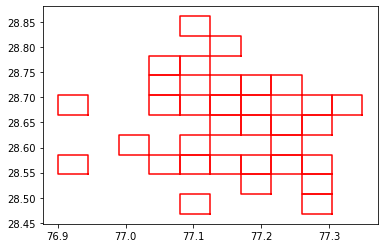

In [31]:
delhi_grid = grid_metadata[grid_metadata["location"]=="Delhi"]
whole_delhi_grid = [shapely.wkt.loads(i) for i in  list(delhi_grid["wkt"])]

for i in whole_delhi_grid:
    x, y = i.exterior.xy
    plt.plot(x, y, c="red")

plt.show()

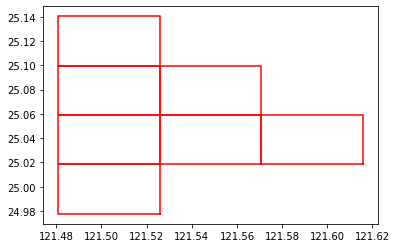

In [34]:
taiwan_grid = grid_metadata[grid_metadata["location"]=="Taipei"]
whole_delhi_grid = [shapely.wkt.loads(i) for i in  list(taiwan_grid["wkt"])]

for i in whole_delhi_grid:
    x, y = i.exterior.xy
    plt.plot(x, y, c="red")

plt.show()

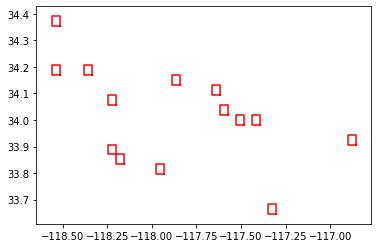

In [32]:
delhi_grid = grid_metadata[grid_metadata["location"]=="Los Angeles (SoCAB)"]
whole_delhi_grid = [shapely.wkt.loads(i) for i in  list(delhi_grid["wkt"])]

for i in whole_delhi_grid:
    x, y = i.exterior.xy
    plt.plot(x, y, c="red")

plt.show()

In [35]:
taiwan_grid

,grid_id,location,tz,wkt
0,1X116,Taipei,Asia/Taipei,"POLYGON ((121.5257644471362 24.97766123020391,..."
8,90BZ1,Taipei,Asia/Taipei,"POLYGON ((121.5706802113421 25.01836939334328,..."
10,9Q6TA,Taipei,Asia/Taipei,"POLYGON ((121.5706802113421 25.05906406274214,..."
30,KW43U,Taipei,Asia/Taipei,"POLYGON ((121.6155959755481 25.01836939334328,..."
42,VR4WG,Taipei,Asia/Taipei,"POLYGON ((121.5257644471362 25.05906406274214,..."
48,XJF9O,Taipei,Asia/Taipei,"POLYGON ((121.5257644471362 25.01836939334328,..."
49,XNLVD,Taipei,Asia/Taipei,"POLYGON ((121.5257644471362 25.09974522235117,..."


In [54]:
data_1X116 = train_labels[ train_labels["grid_id"] == "3S31A"]

In [92]:
data_1X116

data_1X116["datetime"]= pd.to_datetime(data_1X116["datetime"])

<ipython-input-92-d835ac4e39bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1X116["datetime"]= pd.to_datetime(data_1X116["datetime"])


In [93]:
data_1X116.head()

,datetime,grid_id,value
0,2018-02-01 08:00:00+00:00,3S31A,11.400000
49,2018-02-03 08:00:00+00:00,3S31A,27.200000
79,2018-02-04 08:00:00+00:00,3S31A,19.844444
110,2018-02-05 08:00:00+00:00,3S31A,10.600000
141,2018-02-06 08:00:00+00:00,3S31A,20.300000


In [ ]:
data_1X116.head_v

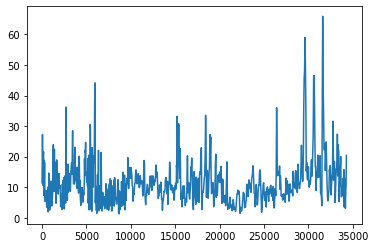

In [90]:
plt.plot(data_1X116["value"])

In [23]:
whole_delhi_grid

In [18]:


import shapely.wkt

P = shapely.wkt.loads('POLYGON ((51.0 3.0, 51.3 3.61, 51.3 3.0, 51.0 3.0))')
print(P)

POLYGON ((51 3, 51.3 3.61, 51.3 3, 51 3))


In [19]:
grid_metadata["wkt"][0]

'POLYGON ((121.5257644471362 24.97766123020391, 121.5257644471362 25.01836939334328, 121.4808486829302 25.01836939334328, 121.4808486829302 24.97766123020391, 121.5257644471362 24.97766123020391))'

In [20]:
satellite_metadata.head()

,granule_id,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size,Date
0,20180201T191000_maiac_la_0.hdf,2018-02-01T17:25:00.000Z,2018-02-01 19:10:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,911405771,10446736,2018-02-01 19:10:00+00:00
1,20180202T195000_maiac_la_0.hdf,2018-02-02T18:05:00.000Z,2018-02-02 19:50:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2244451908,11090180,2018-02-02 19:50:00+00:00
2,20180203T203000_maiac_la_0.hdf,2018-02-03T17:10:00.000Z,2018-02-03 20:30:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3799527997,12468482,2018-02-03 20:30:00+00:00
3,20180204T194000_maiac_la_0.hdf,2018-02-04T17:55:00.000Z,2018-02-04 19:40:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,4105997844,13064424,2018-02-04 19:40:00+00:00
4,20180205T202000_maiac_la_0.hdf,2018-02-05T17:00:00.000Z,2018-02-05 20:20:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1805072340,12549313,2018-02-05 20:20:00+00:00


In [ ]:
locatio

In [16]:
satellite_metadata.groupby("product").size()

product
maiac    6704
misr     1017
dtype: int64

In [65]:
delhi_grids = list(set(delhi_grid["grid_id"]))

In [68]:
ag = train_labels[train_labels["grid_id"].isin(delhi_grids)]
ag.head()

,datetime,grid_id,value
0,2018-02-01T08:00:00Z,3S31A,11.4
1,2018-02-01T08:00:00Z,A2FBI,17.0
2,2018-02-01T08:00:00Z,DJN0F,11.1
3,2018-02-01T08:00:00Z,E5P9N,22.1
4,2018-02-01T08:00:00Z,FRITQ,29.8


In [70]:
ag[:8]

,datetime,grid_id,value
0,2018-02-01T08:00:00Z,3S31A,11.4
1,2018-02-01T08:00:00Z,A2FBI,17.0
2,2018-02-01T08:00:00Z,DJN0F,11.1
3,2018-02-01T08:00:00Z,E5P9N,22.1
4,2018-02-01T08:00:00Z,FRITQ,29.8
5,2018-02-01T08:00:00Z,H96P6,12.8
6,2018-02-01T08:00:00Z,PG3MI,21.0
7,2018-02-01T08:00:00Z,QJHW4,5.2


In [76]:
satellite_metadata

,granule_id,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size,Date
0,20180201T191000_maiac_la_0.hdf,2018-02-01T17:25:00.000Z,2018-02-01 19:10:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,911405771,10446736,2018-02-01 19:10:00+00:00
1,20180202T195000_maiac_la_0.hdf,2018-02-02T18:05:00.000Z,2018-02-02 19:50:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2244451908,11090180,2018-02-02 19:50:00+00:00
2,20180203T203000_maiac_la_0.hdf,2018-02-03T17:10:00.000Z,2018-02-03 20:30:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3799527997,12468482,2018-02-03 20:30:00+00:00
3,20180204T194000_maiac_la_0.hdf,2018-02-04T17:55:00.000Z,2018-02-04 19:40:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,4105997844,13064424,2018-02-04 19:40:00+00:00
4,20180205T202000_maiac_la_0.hdf,2018-02-05T17:00:00.000Z,2018-02-05 20:20:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1805072340,12549313,2018-02-05 20:20:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
7716,20210721T060842_misr_dl_0.nc,2021-07-21T05:11:48.000Z,2021-07-21 06:08:42+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3768009907,30790672,2021-07-21 06:08:42+00:00
7717,20210730T060258_misr_dl_0.nc,2021-07-30T05:11:45.000Z,2021-07-30 06:02:58+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2262052656,29487879,2021-07-30 06:02:58+00:00
7718,20210806T060933_misr_dl_0.nc,2021-08-06T05:18:20.000Z,2021-08-06 06:09:33+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,4079577923,29589362,2021-08-06 06:09:33+00:00
7719,20210815T060400_misr_dl_0.nc,2021-08-15T05:12:45.000Z,2021-08-15 06:04:00+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2932726739,32837807,2021-08-15 06:04:00+00:00


In [75]:
satellite_metadata["time_start"]=="2018-02-01T08:00:00Z"

0       False
1       False
2       False
3       False
4       False
        ...  
7716    False
7717    False
7718    False
7719    False
7720    False
Name: time_start, Length: 7721, dtype: bool

In [12]:
def get_proper_label(text):
    val = "s3://drivendata-competition-airathon-public-us/pm25/train/maiac/"
    return val + text[:4] + "/" +text

In [13]:
def fetch_satellite_meta(metadata, datetime, location, datatype, split):
    if location == "Delhi":
        location = "dl"
    elif location == "Taipei":
        location = "tpe"
    else:
        location = "la"
    metadata = metadata[metadata['location'] == location]
    metadata = metadata[metadata['product'] == datatype]
    metadata = metadata[metadata['split'] == split]
    dateobject = parse(datetime)
    return metadata.loc[(metadata['Date'].dt.month == dateobject.month) & 
                        (metadata['Date'].dt.day == dateobject.day) &
                        (metadata['Date'].dt.year <= dateobject.year)]

In [14]:
def get_grid_data(metadata, grid_id):
    return metadata[metadata["grid_id"] == grid_id]

In [15]:
# Opens the HDF file
def load_data(FILEPATH):
    ds = gdal.Open(FILEPATH)
    return ds

def fetch_subset(granule_id):
    
    result = get_proper_label(granule_id)
    already_files = [ i.split("/")[1] for i in glob.glob("dataset/*")]
    
    if (granule_id not in already_files):
        print("Need to download: "+granule_id)
        already_files+= granule_id
        subprocess.run(["aws", "s3", "cp", result, "./dataset", "--no-sign-request"])
    ds = load_data("dataset/" + granule_id)
    ds.GetSubDatasets()[0]
    raster = gdal.Open(ds.GetSubDatasets()[8][0]) #grid5km:cosSZA features only
    band = raster.GetRasterBand(1)
    band_arr = band.ReadAsArray()
    return band_arr